# Using Qiskit Terra
Update to Qiskit version 0.3.7 (August 2022)

Qiskit Terra contains tools that **define**, **compile** and **execute** quantum circuits on arbitrary **backends**.
It allows users to manipulate qubits by using gates and even construct circuits at the level of **pulses**

## *Transpiling a quantum circuit*

In [ ]:
# Import required fuctions from qiskit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, IBMQ, Aer
IBMQ.load_account()
# set your provider to access Open devices for now
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend("ibmq_lima")

In [ ]:
provider.backends()

# What goes on under the hood when you call `execute`

### Execute calls Assemble to convert the circuit into a Qobj, which is a backend-specific object. 
### While doing so, execute also calls 

   - The transpiler, which converts the circuit into a Directed Acyclic Graph(DAG) of gates,
   - and optimizes the DAG for the target execution backend (DAGs are much easier to optimize than circuits).

### Directed Acyclic Graph (DAG)  are created using  qiskit.compiler.transpile()
### Qobjs are created  using    qiskit.compiler.assemble() 

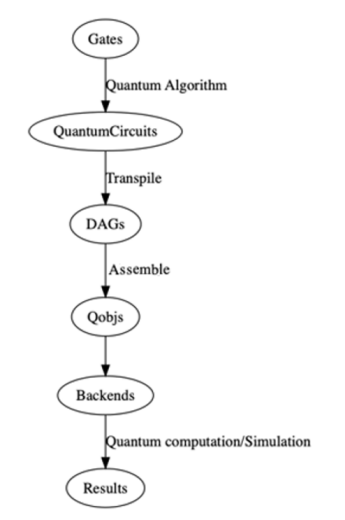

In [ ]:
# let's consider this circuit
ghz = QuantumCircuit(3,3)
ghz.h(0)
ghz.cx(0,1)
ghz.cx(0,2)
ghz.measure([0,1,2], [0,1,2])
ghz.draw()

In [ ]:
# let's create a "qobj" and run it on the simulator without tranpiling it
from qiskit.compiler import assemble
qobj_ghz = assemble(ghz)
print(qobj_ghz)

In [ ]:
# let's execute on the local simulator. .run() method supports only circuit or schedule 
job_sim = Aer.get_backend('qasm_simulator').run(ghz)

print(job_sim.status())
print(job_sim.result().get_counts())
print(job_sim.status())

In [ ]:
# let's run it on a real backend 'ibmq_vigo'
backend = provider.get_backend('ibmq_lima')
job_real = backend.run(ghz)
print(job_real.status())

In [ ]:
print(job_real.status())
print(job_real.result())

In [ ]:
# we retrieve the error message 
print(job_real.error_message())

### We can notice that one instruction assumes a specific coupling map that is not the one that is passed in the execution.  
In fact the program we try to execute do not know the coupling map of the  backen, and the .run() just try to execute the first CNOT gate between qubit 0 and qubit 1 and the second CNOT between qubit 0 and qubit 2. 

Let's look at the coupling map of the backend "ibmq_lima"  


In [ ]:
backend.configuration().coupling_map

We can notice in the coupling map that there is no direct communication between qubit0 and qubit2. This explains the error message "an instruction that assumes a coupling map different than the specified coupling map". In our case the instruction is the CNOT gate

In order to map your program instructions to the correct qubits based on the backend’s coupling map, you must $transpile$ first before execute it. The coupling map for a backend can be found in its configuration data. 



The u* gates represent arbitrary single-qubit rotations of one, two, and three angles.
The tranpiling process "Unroll" the circuit to a given basis (it uses the Unroller pass) 

## *Let's look at lima' coupling map*
 

In [ ]:
from qiskit.visualization import plot_gate_map
backend = provider.get_backend('ibmq_lima')

# plot the coupling map for vigodraw the circuits 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=2)
ghz.draw(output='mpl',scale=1.3, ax=ax[1])
plot_gate_map(backend, plot_directed=True, ax=ax[0])


We can notice in the $coupling$ $map$ that there is no direct communication between $qubit0$ and $qubit2$. This explains the error message "an instruction that assumes a coupling map different than the specified coupling map". In our case the instruction generating the error is the CNOT gate between $qubits$ $0$ and $2$

###  The topology is encoded in what qiskit calls the coupling_map, and the coupling map for a device can be obtained from its configuration

In [ ]:
backend = provider.get_backend('ibmq_lima')
backend.configuration().coupling_map

### As we don't have a connection between qubit 0 and qubit 2, we must transpile our circuit to map the backend configuration  
#### The goal of the transpilation is to 
- Transform a given quantum circuit into one which is executable on a specifc device, preserving measurement outcomes (compatibility)
- Find an implementation which takes maximal advantage of device resources, while minimizing infuence of decoherence and errors.(Optimization)


## *Now it's your turn to play!* - *First challenge*
<div class="alert alert-block alert-info">
<b>Note:</b>
Here's a first challenge for you: Transpile the circuit to "Unroll" to a given basis gate set : ['u3', 'cx']
    
   - Transpile the circuit to unroll non-basis gates using "*ibmq_belem*" as backend 
   - Then draw the transpiled circuit and count the operations (gates)
</div>

In [ ]:
# Consider the circuit below
qr = QuantumRegister(5, 'q')
tpl_circuit = QuantumCircuit(qr)
tpl_circuit.h(qr[3])
tpl_circuit.ccx(qr[0], qr[1], qr[4])
tpl_circuit.cx(qr[4], qr[0])
tpl_circuit.cx(qr[0], qr[1])
tpl_circuit.cx(qr[3], qr[1])
tpl_circuit.cx(qr[3], qr[0])
tpl_circuit.draw()

In [ ]:
# Set your backend to ibmq_belem



In [ ]:
# transpile the circuit and specify the basis gates to unroll to 



In [ ]:
# Draw the circuit when transpiled 



In [ ]:
# counts the operation in the circuit



## *Now it's your turn to play!* - *Second challenge*
<div class="alert alert-block alert-info">
<b>Note:</b>
Here's a second challenge for you: Consider the ciruit ghz2_circ below. 
 
  - First: You must first set your provider to access this premium device (ibmq_toronto) 
    
  - Second:  Tranpile the circuit using "ibmq_toronto" backend, and print out the count operations and depth of the transpiled circuit
  
  - Third: Optimize the transpilation using a specific "initial_layout" to get the best circuit depth 
    
<b>Note:</b> An initial_layout is an initial position of virtual qubits on physical qubits.
            If this layout makes the circuit compatible with the coupling_map constraints, it will be used.
            The final layout is not guaranteed to be the same, as the transpiler may permute qubits through swaps or other means.
</div> 
</div>

In [ ]:
# Consider the circuit "ghz2_circ" below
ghz2_circ = QuantumCircuit(8, 8)
ghz2_circ.h(2)
ghz2_circ.cx(2, 1)
ghz2_circ.cx(1, 0)
ghz2_circ.cx(1, 3)
ghz2_circ.cx(3, 4)
ghz2_circ.ccx(4,6,7)
ghz2_circ.barrier(range(8))
ghz2_circ.measure(range(8), range(8))
ghz2_circ.draw(output='mpl')

#### *First Transpile the circuit using ibmq_toronto as backend*

In [ ]:
# First set your backend as "ibmq_toronto" 



In [ ]:
# transpile your circuit using that backend



In [ ]:
# print the depth and the operation counts for that circuit



In [ ]:
# draw the circuit 



#### *Second: Use an intial layout during transilation that best matches with the circuit*

In [ ]:
# draw the coupling map of the backend "ibmq_toronto"



In [ ]:
# check for a good layout by looking at to which qubits the CNOT and CCX gates are applied in the circuit



In [ ]:
# transpile using an initial_layout 



In [ ]:
print count operations, depth of the circuit,  and draw it



# Challenges solutions 
<div class="alert alert-success">
<b>First Challenge solution</b>

In [55]:
# Consider the circuit below
qr = QuantumRegister(5, 'q')
tpl_circuit = QuantumCircuit(qr)
tpl_circuit.h(qr[3])
tpl_circuit.ccx(qr[0], qr[1], qr[4])
tpl_circuit.cx(qr[4], qr[0])
tpl_circuit.cx(qr[0], qr[1])
tpl_circuit.cx(qr[3], qr[1])
tpl_circuit.cx(qr[3], qr[0])
tpl_circuit.draw()

┌───┐          ┌───┐
q_0: ───────■──┤ X ├──■───────┤ X ├
            │  └─┬─┘┌─┴─┐┌───┐└─┬─┘
q_1: ───────■────┼──┤ X ├┤ X ├──┼──
            │    │  └───┘└─┬─┘  │  
q_2: ───────┼────┼─────────┼────┼──
     ┌───┐  │    │         │    │  
q_3: ┤ H ├──┼────┼─────────■────■──
     └───┘┌─┴─┐  │                 
q_4: ─────┤ X ├──■─────────────────
          └───┘

In [41]:
# specify ibm_belem as backend
backend = provider.get_backend('ibmq_belem')

In [63]:
# Specify the basis gates to unroll to 
from qiskit.compiler import transpile
trans = transpile(tpl_circuit, backend, basis_gates=['u3', 'cx'])

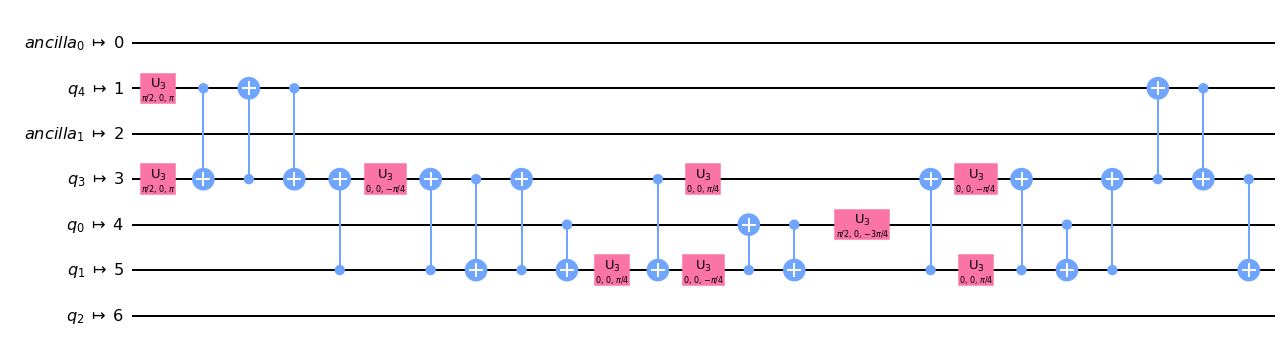

In [64]:
# draw the circuit transpiled 
trans.draw(output='mpl')

In [65]:
# print the count operations to get the number of gates in the circuit 
print (trans.count_ops())

OrderedDict([('cx', 18), ('u3', 9)])


<div class="alert alert-success">
<b>Second Challenge solution</b>

OrderedDict([('cx', 43), ('rz', 12), ('measure', 8), ('sx', 3), ('barrier', 1)])
Depth: 31


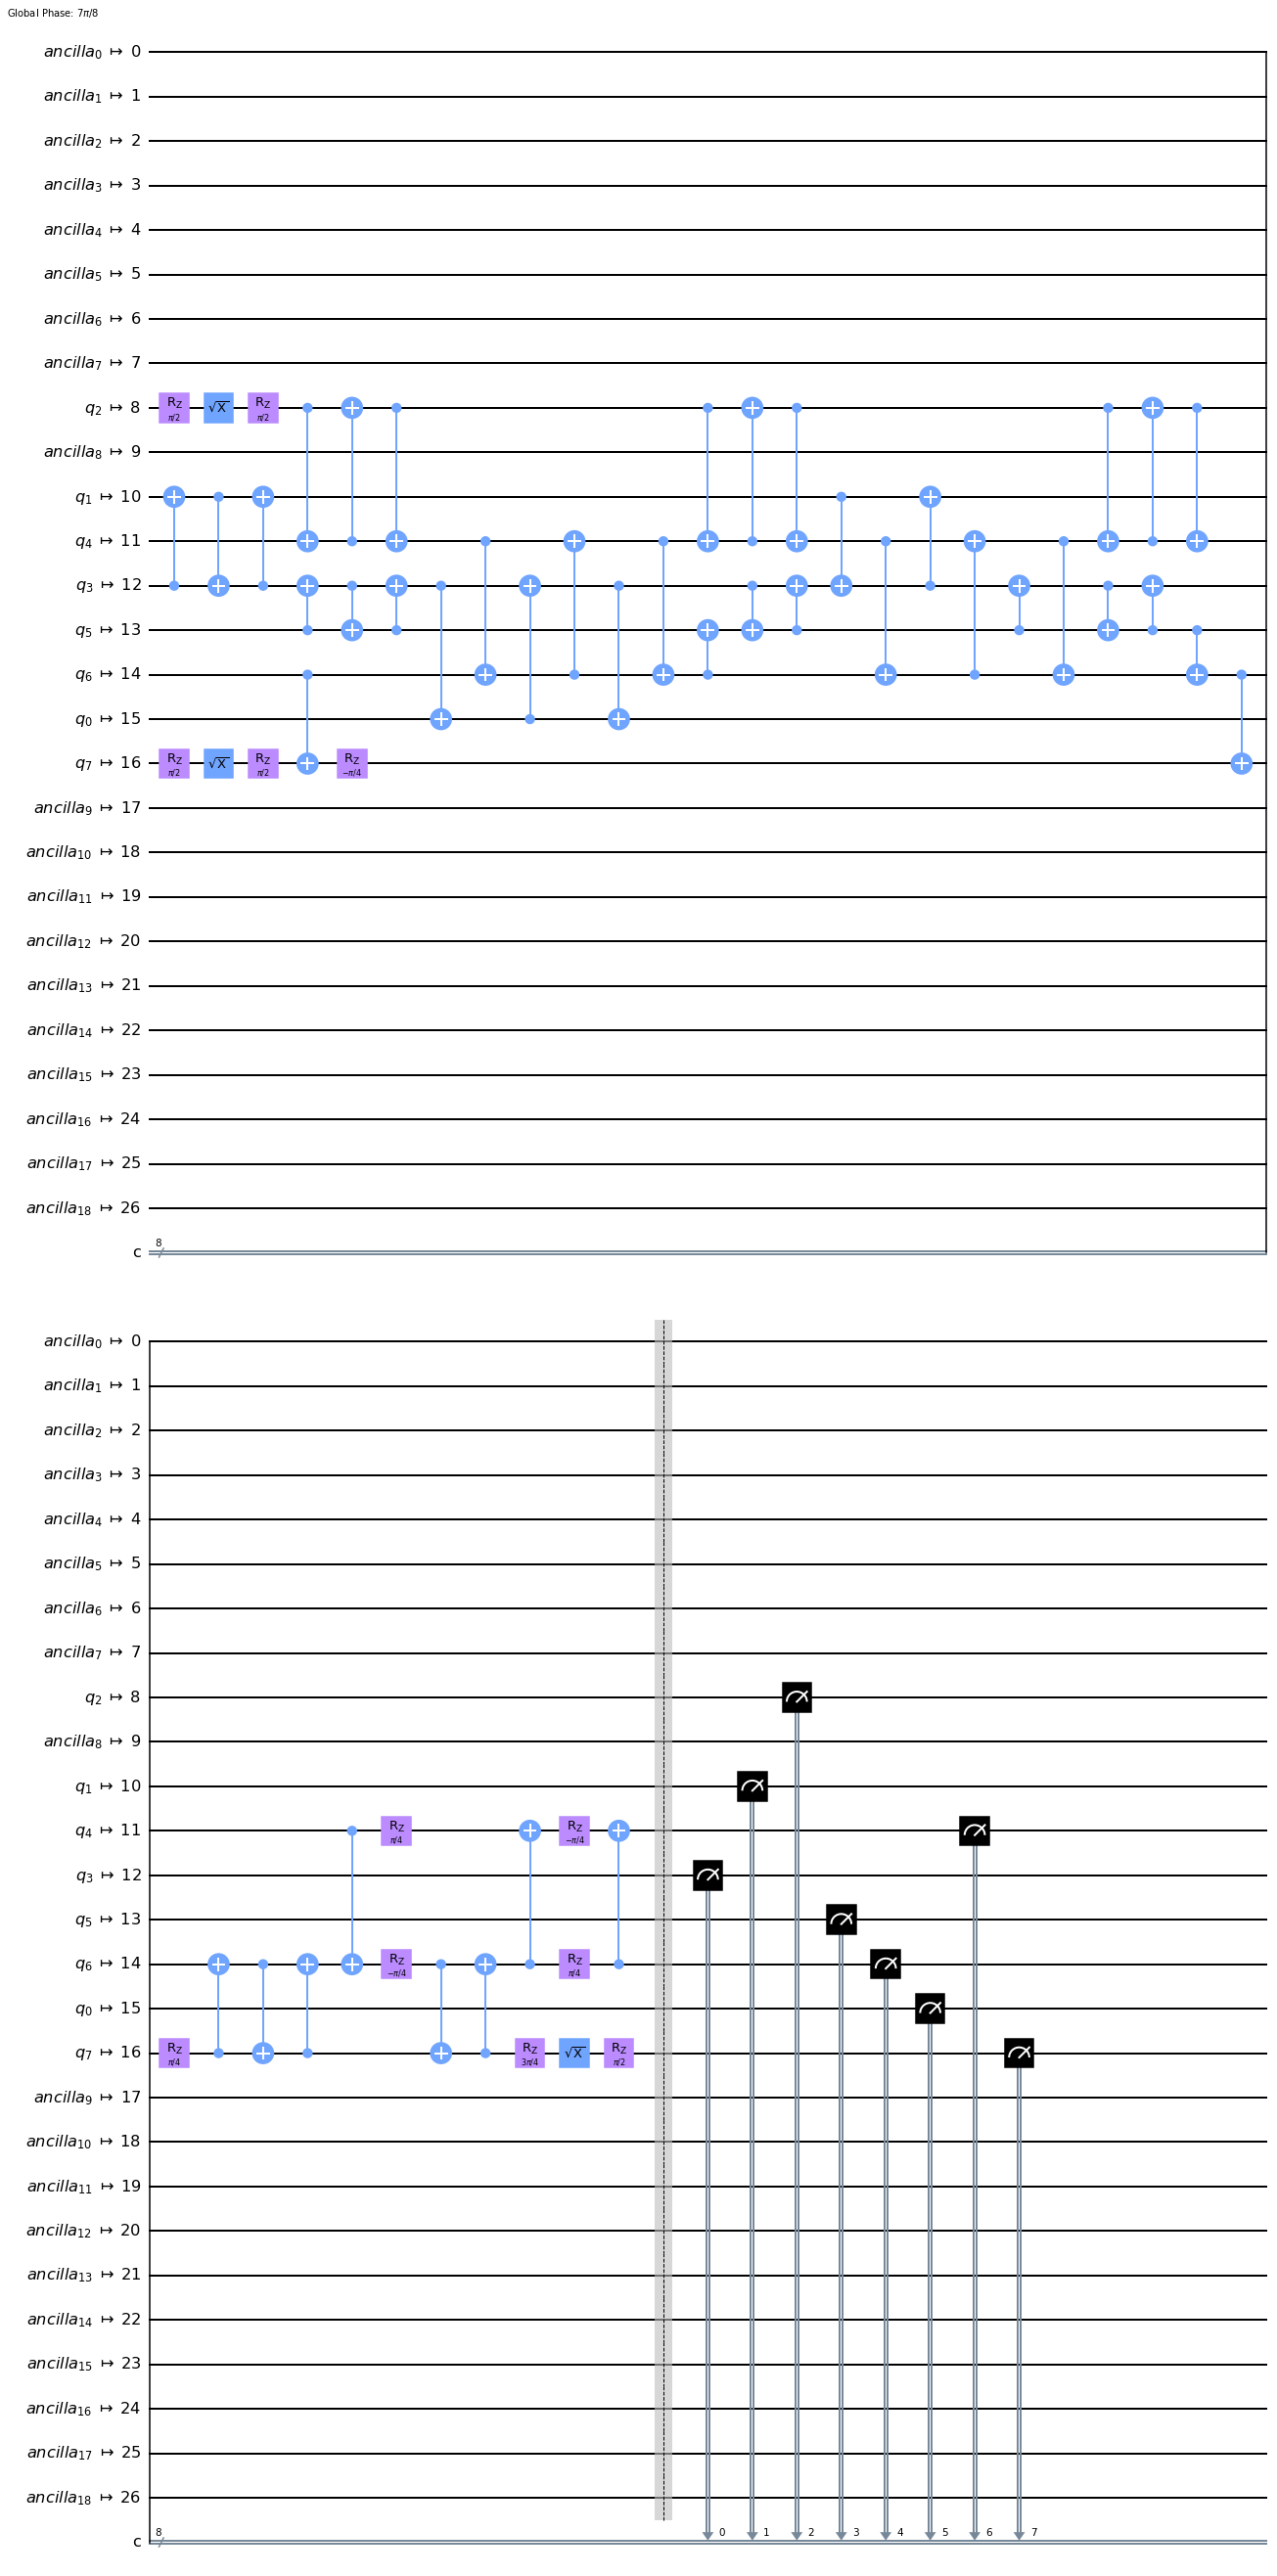

In [91]:
# Set the backend to "ibmq_toronto"
provider = IBMQ.get_provider(hub = 'ibm-q-internal', group = 'support', project = 'core-team')
backend = provider.get_backend('ibmq_toronto')


# Transpile the circuit 
trans = transpile(ghz2_circ, backend)

# Print out the count of operations 
print(trans.count_ops())

# Print the depth of the circuit
print('Depth:', trans.depth())

# Draw the circuit when transpiled
trans.draw(output='mpl')


##### *Second: Use an intial layout during transilation that best matches with the circuit* 

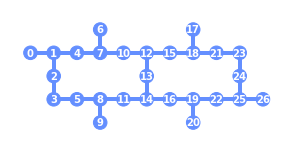

In [69]:
# Check the coupling map of your backend 
# Our GHZ circuit consists of a qubit(0) coupled to qubit(1), qubit(1) coupled to qubit(2), qubit(3) coupled to qubit(4).
# We can notice however that qubit(1) is also coupled to qubit(3).
# Look at the gate map to find the best mapping

plot_gate_map(backend, plot_directed=True)

OrderedDict([('cx', 20), ('rz', 12), ('measure', 8), ('sx', 3), ('barrier', 1)])
Depth: 20


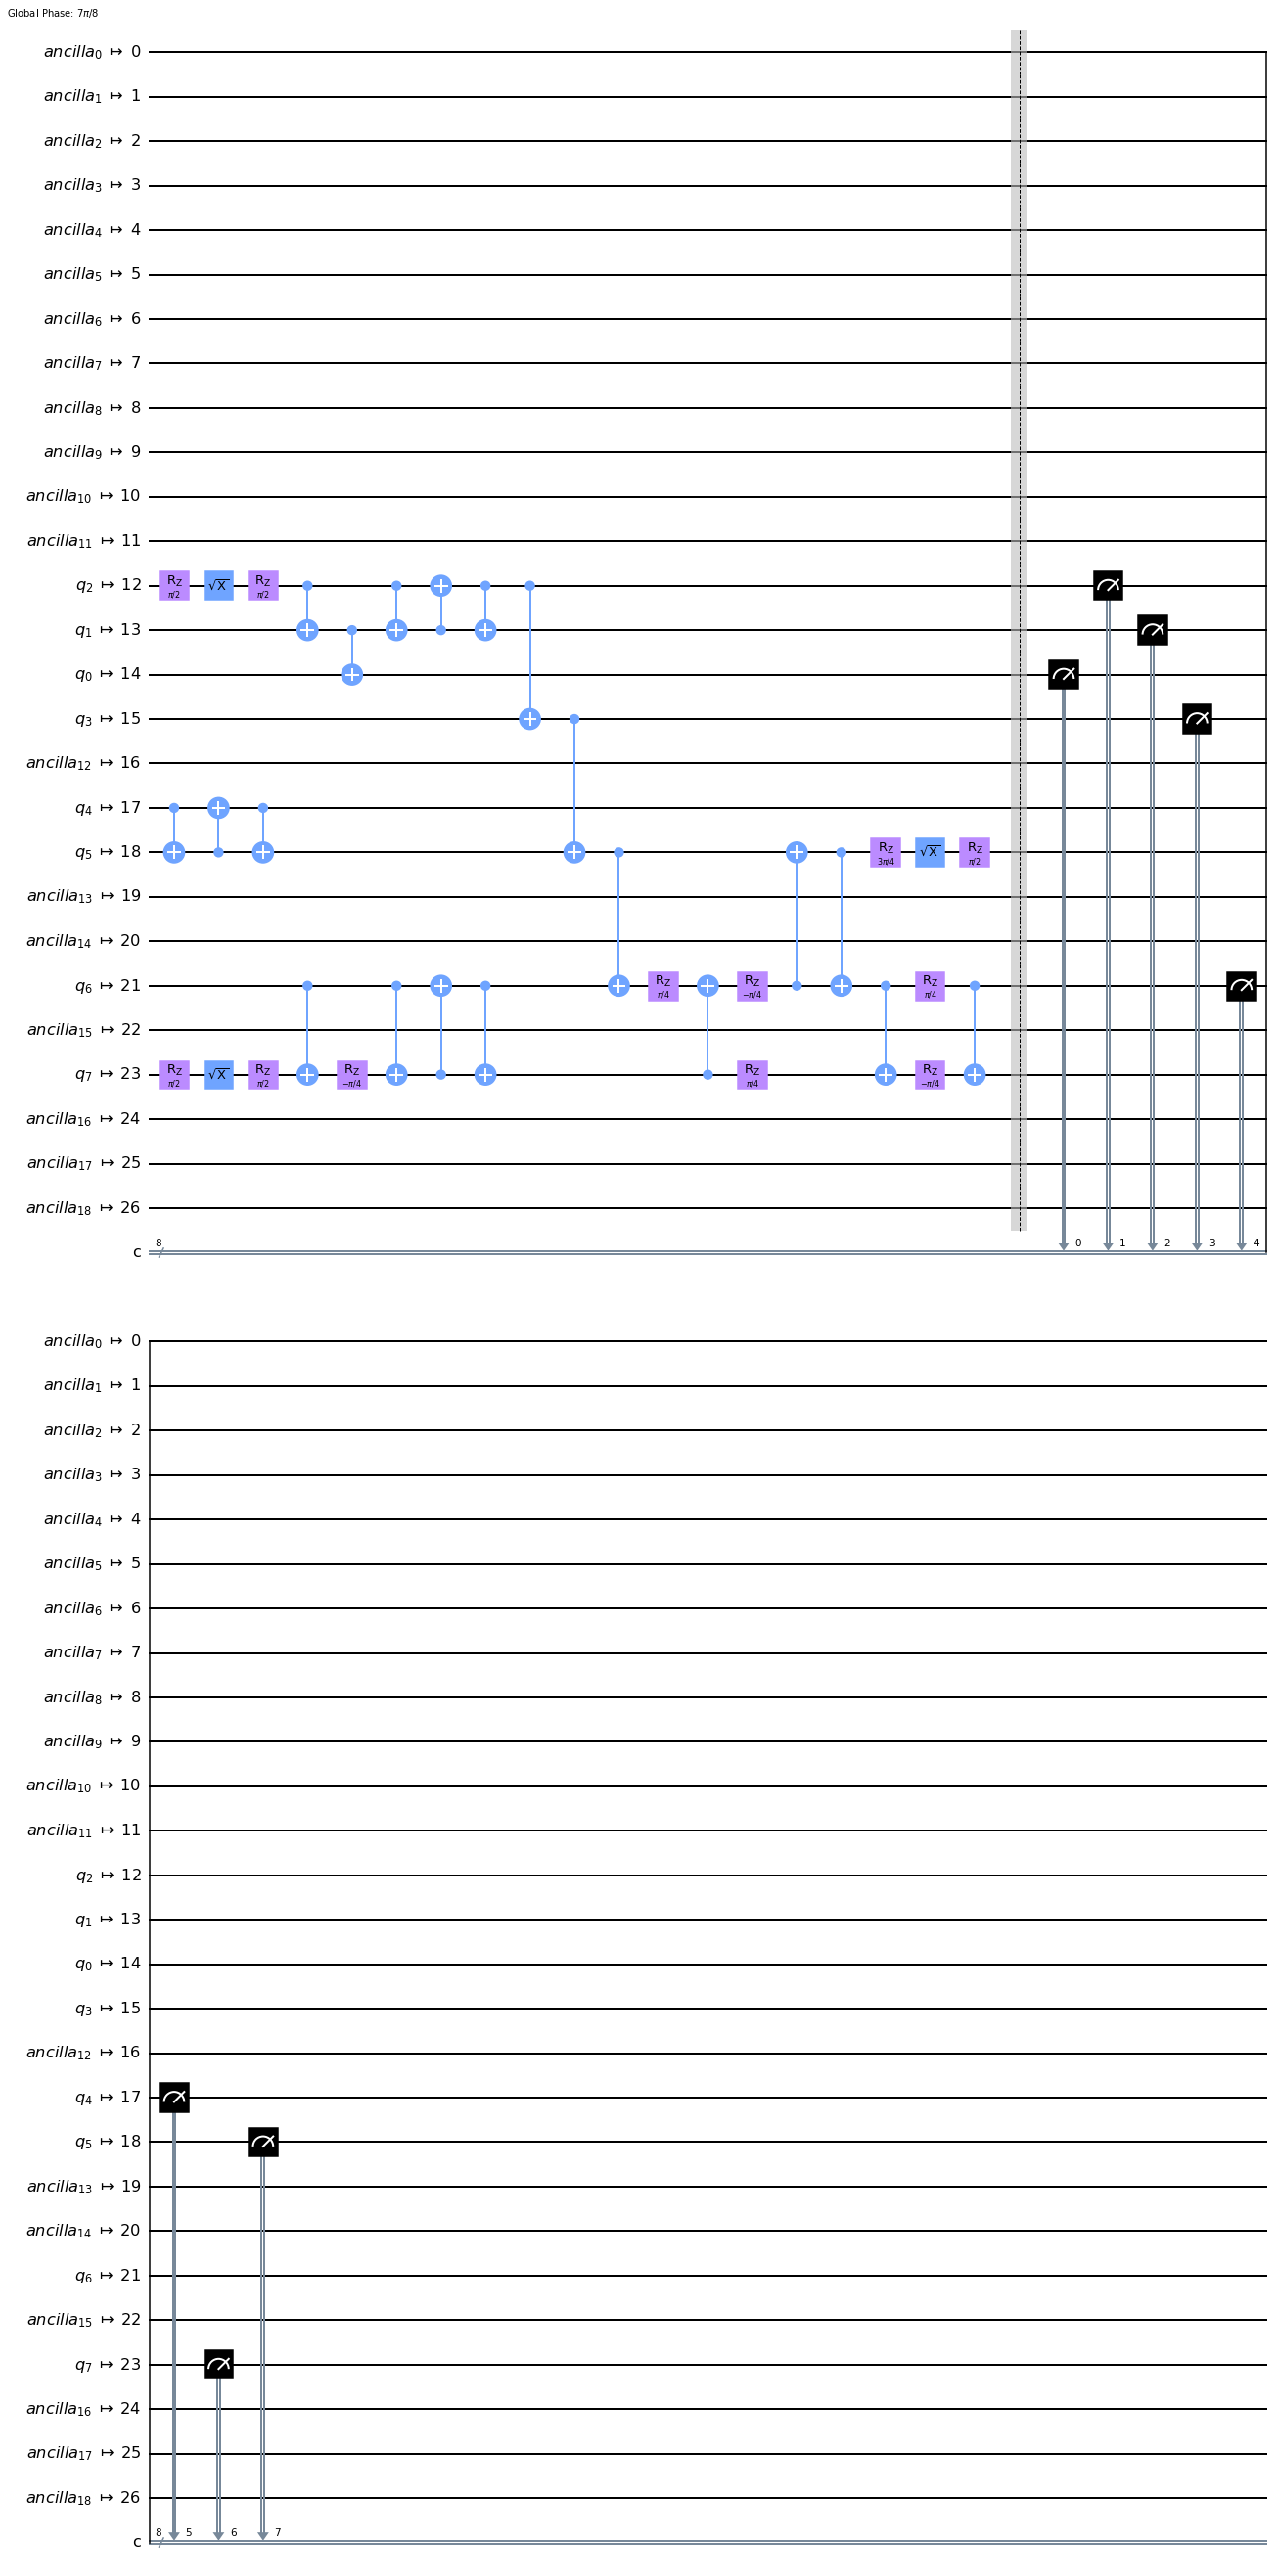

In [97]:
# looking at the cnot gates in the circuit, 
# we have a 
# cnot for qubits0 and qubit1
# cnot qubit1 and qubit2
# cnot qubit3 and qubit4
# cnot qubit1 and qubit3 
# qubit1 must be connected to qubit2 and qubit3 as a good layout 
# qubits 4 6 and 7 also to be connected 

# One good layout here below
trans = transpile(ghz2_circ, backend, initial_layout=[14,13,12,15,17,18,21,23])

print(trans.count_ops())
print('Depth:', trans.depth())
trans.draw(output='mpl')